In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
import matplotlib.pyplot as plt



In [2]:
# 加載數據
data = pd.read_csv('2023_09_2024_08_AQI_Weather_dataset.csv')

data.rename(columns={
    '測站氣壓(hPa)': 'station_pressure_hpa',
    '氣溫(℃)': 'temperature_c',
    '相對溼度(%)': 'relative_humidity',
    '風速(m/s)': 'wind_speed_m_s',
    '風向(360degree)': 'wind_direction_deg',
    #'最大瞬間風(m/s)': 'max_instant_wind_m_s',
    #'最大瞬間風風向(360degree)': 'max_instant_wind_direction_deg',
    '降水量(mm)': 'precipitation_mm'
}, inplace=True)

# 選擇需要的欄位
features = ['station_pressure_hpa', 'temperature_c', 'relative_humidity', 'wind_speed_m_s',
    'wind_direction_deg', 
    'precipitation_mm', 'pm2.5', 'pm10', 'so2', 'no2', 'nox', 'o3', 'co', 'o3_8hr',
    'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg', 'no']
target = 'aqi'

# 將 AQI 轉為分級
def map_aqi_to_label(aqi):
    if aqi <= 50:
        return 0  # 良好
    elif aqi <= 100:
        return 1  # 普通
    elif aqi <= 150:
        return 2  # 對敏感族群不健康
    elif aqi <= 200:
        return 3  # 對所有族群不健康
    elif aqi <= 300:
        return 4  # 非常不健康
    else:
        return 5  # 危害

# 定義函數來計算分類指標
def calculate_classification_metrics(y_true, y_pred, label=""):
    # 將連續值轉換為分類標籤
    y_true_labels = np.array([map_aqi_to_label(aqi) for aqi in y_true.ravel()])
    y_pred_labels = np.array([map_aqi_to_label(aqi) for aqi in y_pred.ravel()])
    
    # 計算分類指標
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    recall = recall_score(y_true_labels, y_pred_labels, average="macro")
    f1 = f1_score(y_true_labels, y_pred_labels, average="macro")
    #auroc = roc_auc_score(y_true_labels, y_pred_labels)
    
    print(f"{label} Accuracy: {accuracy:.3f}")
    print(f"{label} Recall (Macro): {recall:.3f}")
    print(f"{label} F1-Score (Macro): {f1:.3f}")
    #print(f"{label} AUROC: {auroc:.3f}")

# 滑動窗口生成器
def create_windowed_data_all(data, features, target, input_steps, output_steps):
    X = []
    y = []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[features].iloc[i:i + input_steps].values.astype('float32'))
        y.append(data[target].iloc[i + input_steps:i + input_steps + output_steps].values.astype('float32'))
    return np.array(X), np.array(y)

def plot_feature_importance(model, feature_names, top_n=10):
    """
    繪製特徵重要性圖。
    Args:
        model: 訓練後的 XGBoost 模型。
        feature_names: 特徵名稱列表。
        top_n: 顯示的特徵數量。
    """
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values(by="importance", ascending=False).head(top_n)
    
    # 繪圖
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["feature"], importance_df["importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Feature Importance")
    plt.gca().invert_yaxis()  # 翻轉 Y 軸，重要特徵在頂部
    plt.show()
    
    return importance_df


(114191, 1, 19)
(114191, 1)
XGB Fit time: 0.3747 seconds
XGB Predict time: 0.0059 seconds
XGBoost (Short-Term):
MSE: 13.850524
MAE: 2.251422
XGBoost (Short) Accuracy: 0.954
XGBoost (Short) Recall (Macro): 0.842
XGBoost (Short) F1-Score (Macro): 0.870


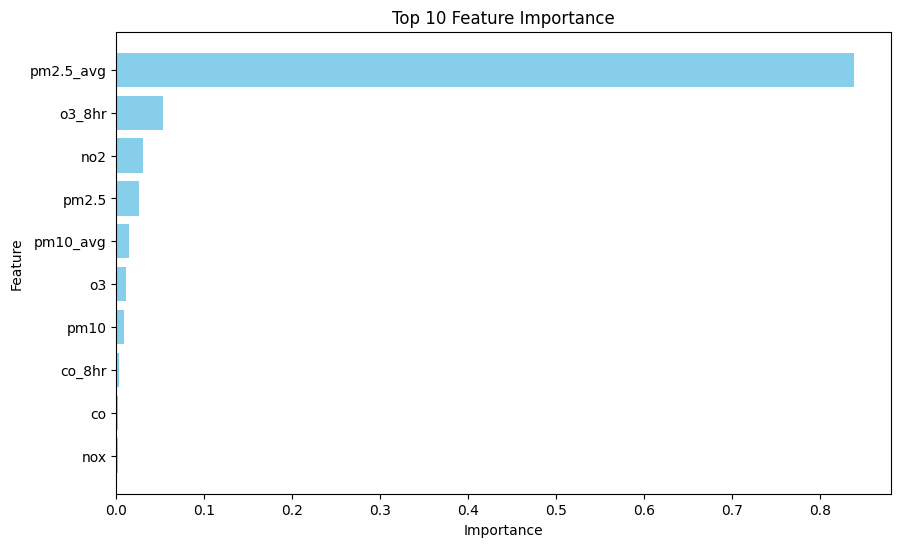

Top 10 Features:
      feature  importance
15  pm2.5_avg    0.839139
13     o3_8hr    0.052943
9         no2    0.030282
6       pm2.5    0.025432
16   pm10_avg    0.013931
11         o3    0.011235
7        pm10    0.008667
14     co_8hr    0.002804
12         co    0.002242
10        nox    0.002198


In [3]:
# 初始化模型
xgb_short = XGBRegressor(random_state=42)

# 短期
X_short, y_short = create_windowed_data_all(data, features, target, input_steps=1, output_steps=1)
X_train_short, X_test_short, y_train_short, y_test_short= train_test_split(X_short, y_short, test_size=0.2, random_state=42)

print(X_short.shape)
print(y_short.shape)

# 訓練模型
X_train_flat_short = X_train_short.reshape(X_train_short.shape[0], -1)  # 展平特徵
start_time = time.time()
xgb_short.fit(X_train_flat_short, y_train_short)
fit_time = time.time() - start_time
print(f"XGB Fit time: {fit_time:.4f} seconds")


# 測試模型
X_test_flat_short = X_test_short.reshape(X_test_short.shape[0], -1)
start_time = time.time()
y_pred_xgb_short = xgb_short.predict(X_test_flat_short)
predict_time = time.time() - start_time
print(f"XGB Predict time: {predict_time:.4f} seconds")

# 評估
print("XGBoost (Short-Term):")
print("MSE:", mean_squared_error(y_test_short, y_pred_xgb_short))
print("MAE:", mean_absolute_error(y_test_short, y_pred_xgb_short))

calculate_classification_metrics(y_test_short, y_pred_xgb_short, "XGBoost (Short)")
# 繪製特徵重要性圖
top_10_features_1hr = plot_feature_importance(xgb_short, features, top_n=10)
print("Top 10 Features:")
print(top_10_features_1hr)


In [4]:
# 初始化模型
xgb_mid = XGBRegressor(random_state=42)

X_mid, y_mid = create_windowed_data_all(data, features, target, input_steps=24, output_steps=1)
X_train_mid, X_test_mid, y_train_mid, y_test_mid= train_test_split(X_mid, y_mid, test_size=0.2, random_state=42)

print(X_mid.shape)
print(y_mid.shape)

# 訓練模型
X_train_flat_mid = X_train_mid.reshape(X_train_mid.shape[0], -1)
start_time = time.time()
xgb_mid.fit(X_train_flat_mid, y_train_mid)
fit_time = time.time() - start_time
print(f"XGB Fit time: {fit_time:.4f} seconds")

# 測試模型
X_test_flat_mid = X_test_mid.reshape(X_test_mid.shape[0], -1)
start_time = time.time()
y_pred_xgb_mid = xgb_mid.predict(X_test_flat_mid)
predict_time = time.time() - start_time
print(f"XGB Predict time: {predict_time:.4f} seconds")

# 評估
print("XGBoost (Mid-Term):")
print("MSE:", mean_squared_error(y_test_mid, y_pred_xgb_mid))
print("MAE:", mean_absolute_error(y_test_mid, y_pred_xgb_mid))

calculate_classification_metrics(y_test_mid, y_pred_xgb_mid, "XGBoost (Mid)")


(114168, 24, 19)
(114168, 1)
XGB Fit time: 4.8199 seconds
XGB Predict time: 0.0291 seconds
XGBoost (Mid-Term):
MSE: 12.760671
MAE: 2.1703756
XGBoost (Mid) Accuracy: 0.955
XGBoost (Mid) Recall (Macro): 0.859
XGBoost (Mid) F1-Score (Macro): 0.885


In [5]:
# 初始化模型
xgb_long = MultiOutputRegressor(XGBRegressor(random_state=42))

X_long, y_long = create_windowed_data_all(data, features, target, input_steps=24, output_steps=24)
X_train_long, X_test_long, y_train_long, y_test_long= train_test_split(X_long, y_long, test_size=0.2, random_state=42)

print(X_long.shape)
print(y_long.shape)

# 訓練模型
X_train_flat_long = X_train_long.reshape(X_train_long.shape[0], -1)
start_time = time.time()
xgb_long.fit(X_train_flat_long, y_train_long)
fit_time = time.time() - start_time
print(f"XGB Fit time: {fit_time:.4f} seconds")

# 測試模型
X_test_flat_long = X_test_long.reshape(X_test_long.shape[0], -1)
start_time = time.time()
y_pred_xgb_long = xgb_long.predict(X_test_flat_long)
predict_time = time.time() - start_time
print(f"XGB Predict time: {predict_time:.4f} seconds")

# 評估
print("XGBoost (long-Term):")
print("MSE:", mean_squared_error(y_test_long, y_pred_xgb_long))
print("MAE:", mean_absolute_error(y_test_long, y_pred_xgb_long))

for model_name, y_pred_long in zip(
    ["XGBoost (Long)"],
    [y_pred_xgb_long]
):
# 因為長期預測輸出為 24 小時的結果，需要逐時展平處理
    calculate_classification_metrics(y_test_long.ravel(), y_pred_long.ravel(), model_name)

(114145, 24, 19)
(114145, 24)
XGB Fit time: 130.1781 seconds
XGB Predict time: 0.5371 seconds
XGBoost (long-Term):
MSE: 145.41693
MAE: 8.418275
XGBoost (Long) Accuracy: 0.832
XGBoost (Long) Recall (Macro): 0.570
XGBoost (Long) F1-Score (Macro): 0.606
